# ML - Flight Arrival Delay Prediction

## imports

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Adding the root directory 
#of the project to the Python path, so that it will also look here for modules

import config

import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

from config import RAW_FLIGHTS



In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
df_flights = pd.read_csv(RAW_FLIGHTS)

/var/folders/kl/2y01c7y51cj42bdww37cvc5c0000gn/T/ipykernel_75396/1303910650.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv(RAW_FLIGHTS)


In [4]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [ ]:
df_flights.describe

## Define goal: create an algorithm to predict if a flight will ARRIVE with DELAY

### Handle NANs

In [6]:
df_flights.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

### Drop rows with small percentage of NAN values

### Columns with rows having an insignificant percentage of NANs

In [ ]:
NANS_to_drop = [
    'TAIL_NUMBER', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 
    'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 
    'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']

df_flights_clean = df_flights.dropna(subset=NANS_to_drop).copy()


### Columns with a significant number of NANs, it this situation, it's suitable to convert these NANs to 0

In [8]:
NANS_to_convert = ['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 
                   'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

df_flights_clean.loc[:, NANS_to_convert] = df_flights_clean.loc[:, NANS_to_convert].fillna(0)


In [9]:
df_flights_clean.isna().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
CANCELLATION_REASON    0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64

## Determine if a arriving flight will be delayed or not (delayed = arriving more than 15 or more minutes after scheduled arrival time )

### Classification - Define classification target

In [10]:
df_flights_clean['ARRIVAL_DELAY_15'] = df_flights_clean['ARRIVAL_DELAY'] >= 15


### Exploring

In [11]:
df_filtered_arrivals = df_flights_clean[df_flights_clean['ARRIVAL_DELAY'] >= 15]
df_filtered_arrivals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1063439 entries, 27 to 5819071
Data columns (total 32 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 1063439 non-null  int64  
 1   MONTH                1063439 non-null  int64  
 2   DAY                  1063439 non-null  int64  
 3   DAY_OF_WEEK          1063439 non-null  int64  
 4   AIRLINE              1063439 non-null  object 
 5   FLIGHT_NUMBER        1063439 non-null  int64  
 6   TAIL_NUMBER          1063439 non-null  object 
 7   ORIGIN_AIRPORT       1063439 non-null  object 
 8   DESTINATION_AIRPORT  1063439 non-null  object 
 9   SCHEDULED_DEPARTURE  1063439 non-null  int64  
 10  DEPARTURE_TIME       1063439 non-null  float64
 11  DEPARTURE_DELAY      1063439 non-null  float64
 12  TAXI_OUT             1063439 non-null  float64
 13  WHEELS_OFF           1063439 non-null  float64
 14  SCHEDULED_TIME       1063439 non-null  float64
 15  EL

In [12]:
df_filtered_arrivals.head(15)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ARRIVAL_DELAY_15
27,2015,1,1,4,NK,597,N528NK,MSP,FLL,115,127.0,12.0,14.0,141.0,207.0,220.0,166.0,1487,527.0,40.0,542,607.0,25.0,0,0,0,25.0,0.0,0.0,0.0,0.0,True
30,2015,1,1,4,NK,168,N629NK,PHX,ORD,125,237.0,72.0,9.0,246.0,204.0,175.0,156.0,1440,622.0,10.0,549,632.0,43.0,0,0,0,43.0,0.0,0.0,0.0,0.0,True
35,2015,1,1,4,HA,17,N389HA,LAS,HNL,145,145.0,0.0,16.0,201.0,370.0,385.0,361.0,2762,602.0,8.0,555,610.0,15.0,0,0,0,0.0,0.0,15.0,0.0,0.0,True
50,2015,1,1,4,B6,1030,N239JB,BQN,MCO,307,304.0,-3.0,25.0,329.0,173.0,196.0,160.0,1129,509.0,11.0,500,520.0,20.0,0,0,0,20.0,0.0,0.0,0.0,0.0,True
52,2015,1,1,4,B6,2134,N307JB,SJU,MCO,400,535.0,95.0,9.0,544.0,185.0,175.0,163.0,1189,727.0,3.0,605,730.0,85.0,0,0,0,0.0,0.0,85.0,0.0,0.0,True
55,2015,1,1,4,B6,2276,N646JB,SJU,BDL,438,550.0,72.0,15.0,605.0,241.0,258.0,237.0,1666,902.0,6.0,739,908.0,89.0,0,0,0,17.0,0.0,72.0,0.0,0.0,True
70,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,515,703.0,108.0,15.0,718.0,161.0,155.0,133.0,1121,1031.0,7.0,856,1038.0,102.0,0,0,0,0.0,0.0,0.0,0.0,102.0,True
73,2015,1,1,4,US,425,N174US,PDX,PHX,520,620.0,60.0,13.0,633.0,150.0,150.0,132.0,1009,945.0,5.0,850,950.0,60.0,0,0,0,0.0,0.0,60.0,0.0,0.0,True
74,2015,1,1,4,AA,89,N3KVAA,IAH,MIA,520,618.0,58.0,19.0,637.0,141.0,137.0,111.0,964,928.0,7.0,841,935.0,54.0,0,0,0,0.0,0.0,54.0,0.0,0.0,True
86,2015,1,1,4,AA,328,N4XKAA,DEN,DFW,530,623.0,53.0,32.0,655.0,125.0,138.0,96.0,641,931.0,10.0,835,941.0,66.0,0,0,0,13.0,0.0,53.0,0.0,0.0,True


<Axes: >

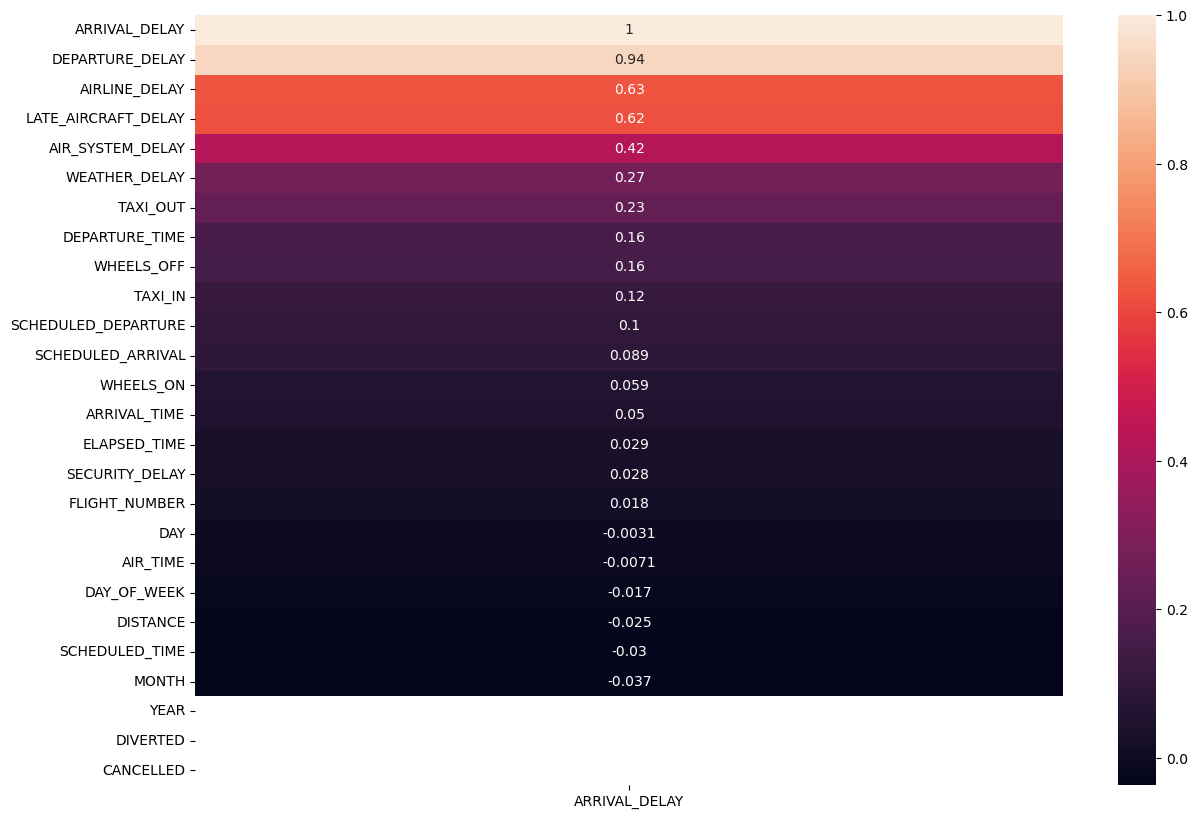

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only numeric columns
corr = df_flights_clean.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr[['ARRIVAL_DELAY']].sort_values(by='ARRIVAL_DELAY', ascending=False), annot=True)


<Axes: xlabel='ARRIVAL_DELAY_15', ylabel='DEPARTURE_DELAY'>

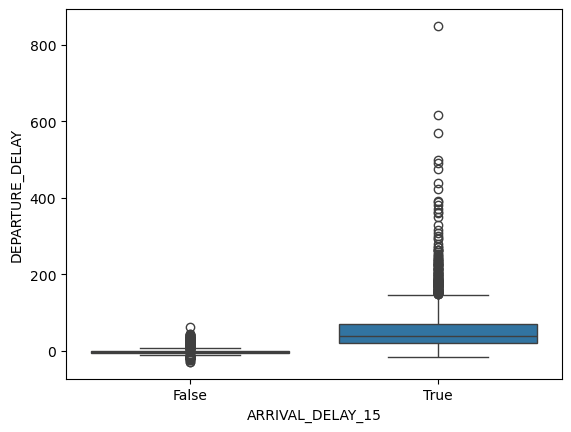

In [14]:
sns.boxplot(x='ARRIVAL_DELAY_15', y='DEPARTURE_DELAY', data=df_flights_clean.sample(10000))


## Prepare and split data

In [15]:
features = ['DEPARTURE_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'AIR_SYSTEM_DELAY',
            'WEATHER_DELAY', 'TAXI_OUT', 'DEPARTURE_TIME', 'WHEELS_OFF', 'TAXI_IN', 'SCHEDULED_DEPARTURE']


X = df_flights_clean[features].copy()
y = df_flights_clean['ARRIVAL_DELAY_15']


### Encode categorical variables

In [13]:
from sklearn.preprocessing import LabelEncoder

for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
    X[col] = X[col].astype(str)

# Encode categorical variables
for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col])


In [16]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


### New

In [17]:
### train the model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

### Predict & Check metrics

In [18]:
from sklearn.metrics import classification_report

prediction = logreg.predict(X_test)

print(classification_report(y_test,prediction))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1162663
        True       1.00      1.00      1.00    265839

    accuracy                           1.00   1428502
   macro avg       1.00      1.00      1.00   1428502
weighted avg       1.00      1.00      1.00   1428502



In [23]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1428502 entries, 2167050 to 2601406
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   DEPARTURE_DELAY      1428502 non-null  float64
 1   AIRLINE_DELAY        1428502 non-null  float64
 2   LATE_AIRCRAFT_DELAY  1428502 non-null  float64
 3   AIR_SYSTEM_DELAY     1428502 non-null  float64
 4   WEATHER_DELAY        1428502 non-null  float64
 5   TAXI_OUT             1428502 non-null  float64
 6   DEPARTURE_TIME       1428502 non-null  float64
 7   WHEELS_OFF           1428502 non-null  float64
 8   TAXI_IN              1428502 non-null  float64
 9   SCHEDULED_DEPARTURE  1428502 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 119.9 MB


In [22]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 1428502 entries, 2167050 to 2601406
Series name: ARRIVAL_DELAY_15
Non-Null Count    Dtype
--------------    -----
1428502 non-null  bool 
dtypes: bool(1)
memory usage: 12.3 MB


### Feature scaling

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [20]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9998396922090413
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1162663
        True       1.00      1.00      1.00    265839

    accuracy                           1.00   1428502
   macro avg       1.00      1.00      1.00   1428502
weighted avg       1.00      1.00      1.00   1428502



In [24]:
y_train.shape

(4285506,)

In [ ]:
y_train.value_counts()


ARRIVAL_DELAY_15
False    3487906
True      797600
Name: count, dtype: int64

In [25]:
df_flights_clean.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'ARRIVAL_DELAY_15'],
      dtype='object')

## Define new features, remove 'DEPARTURE_DELAY' to see how the model performs

In [22]:
features_1 = df_flights[features].drop('DEPARTURE_DELAY', axis=1)
X_1 = features_1
y = df_flights['ARRIVAL_DELAY_15']


In [ ]:
X_1.head()

,MONTH,DAY_OF_WEEK,AIRLINE,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIR_SYSTEM_DELAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE
0,1,4,AS,NaN,NaN,NaN,NaN,ANC,SEA,5,1448
1,1,4,AA,NaN,NaN,NaN,NaN,LAX,PBI,10,2330
2,1,4,US,NaN,NaN,NaN,NaN,SFO,CLT,20,2296
3,1,4,AA,NaN,NaN,NaN,NaN,LAX,MIA,20,2342
4,1,4,AS,NaN,NaN,NaN,NaN,SEA,ANC,25,1448


In [24]:
X_1.isna().sum()

MONTH                        0
DAY_OF_WEEK                  0
AIRLINE                      0
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
AIR_SYSTEM_DELAY       4755640
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DISTANCE                     0
dtype: int64

In [26]:
X_1.fillna(0, inplace=True)
X_1.isna().sum()

MONTH                  0
DAY_OF_WEEK            0
AIRLINE                0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
AIR_SYSTEM_DELAY       0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DISTANCE               0
dtype: int64

## Split and train data

### Prepare categorical data for ML

In [35]:
X_1.dtypes


MONTH                    int64
DAY_OF_WEEK              int64
AIRLINE                 object
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
AIR_SYSTEM_DELAY       float64
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DISTANCE                 int64
dtype: object

### Use LabelEncoder to encode categorical data

In [36]:
for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
    X_1[col] = X_1[col].astype(str)

for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
    le = LabelEncoder()
    X_1.loc[:, col] = le.fit_transform(X_1[col])

In [27]:
X_train_1, y_train_1, X_test_1, y_train_1 = train_test_split(X_1, y, test_size=.25, random_state=0) 

In [28]:
model.fit(X_train_1, y_train_1)


ValueError: could not convert string to float: 'B6'

### Label encoding for categorical variables

In [30]:
X_1.dtypes
    

MONTH                    int64
DAY_OF_WEEK              int64
AIRLINE                 object
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
AIR_SYSTEM_DELAY       float64
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DISTANCE                 int64
dtype: object

In [33]:
# Iterate over columns with type 'object' to assign them the class 'string'

for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
    X_1[col] = X_1[col].astype(str)

X_1.dtypes



MONTH                    int64
DAY_OF_WEEK              int64
AIRLINE                 object
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
AIR_SYSTEM_DELAY       float64
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DISTANCE                 int64
dtype: object

In [34]:
# Use LabelEncoder to categorical variables
for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
    le = LabelEncoder()
    X_1.loc[:, col] = le.fit_transform(X_1[col])

## Split and train data again after converting 

## Metrics

In [ ]:
y_pred_1 = model.predict(X_test_1, y_test)

print(f'Accuracy:{accuracy_score(y_test, y_pred_1)}')
print(f'Accuracy:{classification_report(y_test, y_pred_1)}')

### OLD

In [ ]:
X_train.isna().sum()

#X_train[['AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'AIR_SYSTEM_DELAY', 'DEPARTURE_DELAY']] = X_train[['AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'AIR_SYSTEM_DELAY', 'DEPARTURE_DELAY']].fillna(0)


# deal with NAN values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


print(X_train.isna().sum())
print(X_test.isna().sum())